In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import cv2                         # To read and manipulate images
import matplotlib.pyplot as plt    # Python 2D plotting library
%matplotlib inline  
from sklearn.preprocessing import LabelEncoder
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from time import time
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import copy
from torch.autograd import Variable
import torch.nn.functional as F
import pickle
from cnn_finetune import make_model
from time import sleep

In [2]:
TRAIN_PATH = 'data/CAX_Superhero_Train/'
TEST_PATH = 'data/CAX_Superhero_Test/'
superhero_dic = {'Ant-Man':'ant_man', 'Aquaman':'aqua_man', 'Avengers':'avengers', 'Batman':'bat_man', 
                 'Black Panther':'black_panther', 'Captain America':'captain_america', 'Catwoman':'cat_woman',
                 'Ghost Rider':'ghostrider', 'Hulk':'hulk', 'Iron Man':'iron_man', 'Spiderman':'spider_man', 
                 'Superman':'super_man'}

labelencoder_dic = {0: 'ant_man', 1: 'aqua_man', 2: 'avengers', 3: 'bat_man', 4: 'black_panther', 5: 'captain_america', 
                    6: 'cat_woman', 7: 'ghostrider', 8: 'hulk', 9: 'iron_man', 10: 'spider_man', 11: 'super_man'}

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = 160

train_df = pd.read_csv('data/train_df.csv')
test_df = pd.read_csv('data/test_df.csv')

torch.random.manual_seed(10);
torch.cuda.manual_seed(10)

In [3]:
#Dataset for PyTorch
class SuperheroesDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.transform = transform
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        img = Image.open(self.x[idx])
        img = img.convert('RGB')
        if self.transform is not None:
            img = self.transform(img)           
        label = self.y[idx]
        out = (img, label)
        return out

#Train model
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=2):
    since = time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    loss_log = {'train':{}, 'val':{}}
    acc_log = {'train':{}, 'val':{}}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if scheduler is not None:
                    scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            loss_log[phase][epoch] = epoch_loss
            acc_log[phase][epoch] = epoch_acc 

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch
        print('lr: ',optimizer.param_groups[0]['lr'])
        print()

    time_elapsed = time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}, epoch {:d}'.format(best_acc, best_epoch))
    

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    # plot graphs
    for phase in loss_log:
        lists = sorted(loss_log[phase].items()) # sorted by key, return a list of tuples
        x, y = zip(*lists) # unpack a list of pairs into two tuples
        plt.figure(1)
        plt.plot(x,y)
    plt.legend(['train', 'val'])
    plt.title('Loss')
    
    for phase in acc_log:
        lists = sorted(acc_log[phase].items()) # sorted by key, return a list of tuples
        x, y = zip(*lists) # unpack a list of pairs into two tuples
        plt.figure(2)
        plt.plot(x,y)
    plt.legend(['train', 'val'])
    plt.title('Accuracy')
    
    return model, loss_log, acc_log

# This is a little utility that we'll use to reset the model if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()    
        
def predict(test_loader, model):
    model.eval()       #Sets the module in evaluation mode
    predictions = []
    
    for i, data in enumerate(tqdm(test_loader)):
        inputs, _ = data
        if use_gpu:
            inputs = Variable(inputs.cuda())
        else:
            inputs = Variable(inputs)
            
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        predictions.append(preds[0])
        sleep(0.01)
    return predictions

def submit_prediction(test_load, model, path):
    predictions = predict(test_load, model)
    d = {'filename': test_df['img_name'], 'Superhero': predictions}
    predict_df = pd.DataFrame(d)
    predict_df = predict_df[['filename', 'Superhero']]
    predict_df['filename'] = predict_df['filename'].map(lambda x: str(x)[:-4])
    predict_df.replace({"Superhero": labelencoder_dic}, inplace=True)

    submission = pd.read_csv('data/Superhero_3375_SampleSubmission.csv')

    # find filename in predict and insert superhero in submission
    for i in tqdm(range(submission.shape[0])):
        filename = submission['filename'].iloc[i]
        submission['Superhero'].iloc[i] = predict_df['Superhero'][predict_df['filename'] == filename].values[0]

    submission.to_csv(path, index=False)

In [17]:
transform_data = transforms.Compose([transforms.Resize(IMG_SIZE),transforms.CenterCrop(IMG_SIZE),transforms.ToTensor()])

transform_train = transforms.Compose([transforms.Resize(IMG_SIZE),
                                     transforms.CenterCrop(IMG_SIZE),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                    ])
transform_test = transforms.Compose([transforms.Resize(IMG_SIZE),
                                     transforms.CenterCrop(IMG_SIZE),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                    ])

use_gpu = torch.cuda.is_available()

labelencoder = LabelEncoder()

x_train_df = train_df['img_path'].values
y_train_df = train_df['superhero'].values
y_train_df = labelencoder.fit_transform(y_train_df)
x_test_df = test_df['img_path'].values

x_train, x_valid, y_train, y_valid = train_test_split(x_train_df, y_train_df, test_size=0.2, random_state=42, 
                                                      shuffle=True, stratify=y_train_df)
x_test = x_test_df
y_test = np.zeros_like(x_test)

batch_size = 32
train_set = SuperheroesDataset(x_train, y_train, transform_train)
train_load = DataLoader(train_set,batch_size=batch_size, pin_memory=True)
valid_set = SuperheroesDataset(x_valid, y_valid, transform_test)
valid_load = DataLoader(valid_set,batch_size=batch_size, pin_memory=True)
test_set = SuperheroesDataset(x_test, y_test, transform_test)
test_load = DataLoader(test_set,batch_size=1, pin_memory=True)

image_datasets = {'train':train_set, 'val':valid_set}
dataloaders    = {'train':train_load, 'val':valid_load}
dataset_sizes  = {'train':len(train_set), 'val':len(valid_set)}

criterion = nn.CrossEntropyLoss()

In [5]:
#Train model
def train_model_batch(model, criterion, optimizer, scheduler=None, num_epochs=2, batch_accum=1):
    since = time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    loss_log = {'train':{}, 'val':{}}
    acc_log = {'train':{}, 'val':{}}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if scheduler is not None:
                    scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            loss_mini_batch = 0

            # Iterate over data.
            for i, data in enumerate(dataloaders[phase]):

                inputs, labels = data

                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)                

                if phase == 'train':
                    loss.backward()

                running_loss += loss.data[0]*inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)


                if (i+1) % batch_accum == 0:
                    optimizer.step()
                    optimizer.zero_grad()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            loss_log[phase][epoch] = epoch_loss
            acc_log[phase][epoch] = epoch_acc 

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch
        print('lr: ',optimizer.param_groups[0]['lr'])
        print()

    time_elapsed = time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}, epoch {:d}'.format(best_acc, best_epoch))
    

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    # plot graphs
    for phase in loss_log:
        lists = sorted(loss_log[phase].items()) # sorted by key, return a list of tuples
        x, y = zip(*lists) # unpack a list of pairs into two tuples
        plt.figure(1)
        plt.plot(x,y)
    plt.legend(['train', 'val'])
    plt.title('Loss')
    
    for phase in acc_log:
        lists = sorted(acc_log[phase].items()) # sorted by key, return a list of tuples
        x, y = zip(*lists) # unpack a list of pairs into two tuples
        plt.figure(2)
        plt.plot(x,y)
    plt.legend(['train', 'val'])
    plt.title('Accuracy')
    
    return model, loss_log, acc_log

In [14]:
model_ft = make_model('densenet121', num_classes=12, pretrained=True, input_size=(160, 160))
model_ft.cuda();

Epoch 0/29
----------
train Loss: 2.2230 Acc: 0.2954
val Loss: 1.9452 Acc: 0.3569
lr:  0.0001

Epoch 1/29
----------
train Loss: 1.8320 Acc: 0.4215
val Loss: 1.7024 Acc: 0.4554
lr:  0.0001

Epoch 2/29
----------
train Loss: 1.6287 Acc: 0.4779
val Loss: 1.6448 Acc: 0.4673
lr:  0.0001

Epoch 3/29
----------
train Loss: 1.5336 Acc: 0.5094
val Loss: 1.6579 Acc: 0.4545
lr:  0.0001

Epoch 4/29
----------
train Loss: 1.4046 Acc: 0.5462
val Loss: 1.5566 Acc: 0.5078
lr:  0.0001

Epoch 5/29
----------
train Loss: 1.2724 Acc: 0.6010
val Loss: 1.5912 Acc: 0.4894
lr:  0.0001

Epoch 6/29
----------
train Loss: 1.1502 Acc: 0.6436
val Loss: 1.5354 Acc: 0.5225
lr:  0.0001

Epoch 7/29
----------
train Loss: 1.0148 Acc: 0.6931
val Loss: 1.9000 Acc: 0.4811
lr:  0.0001

Epoch 8/29
----------
train Loss: 0.9961 Acc: 0.6914
val Loss: 1.7052 Acc: 0.5078
lr:  0.0001

Epoch 9/29
----------
train Loss: 0.9464 Acc: 0.7108
val Loss: 1.5166 Acc: 0.5308
lr:  0.0001

Epoch 10/29
----------
train Loss: 0.8435 Acc: 0.7

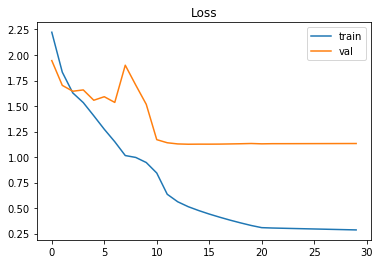

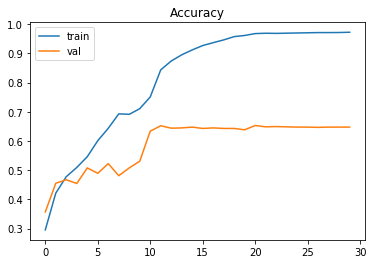

In [7]:
# densenet121, batch_size=32, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_ds121, loss_log, acc_log = train_model_batch(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30, batch_accum=8)

In [8]:
model_ft = make_model('densenet121', num_classes=12, pretrained=True, input_size=(160, 160), dropout_p=0.5)
model_ft.cuda();

Epoch 0/29
----------
train Loss: 2.2490 Acc: 0.2665
val Loss: 1.9560 Acc: 0.3983
lr:  0.0001

Epoch 1/29
----------
train Loss: 1.8874 Acc: 0.4066
val Loss: 1.7641 Acc: 0.4204
lr:  0.0001

Epoch 2/29
----------
train Loss: 1.6894 Acc: 0.4735
val Loss: 1.5928 Acc: 0.4719
lr:  0.0001

Epoch 3/29
----------
train Loss: 1.5537 Acc: 0.5078
val Loss: 1.5166 Acc: 0.5014
lr:  0.0001

Epoch 4/29
----------
train Loss: 1.4185 Acc: 0.5538
val Loss: 1.6764 Acc: 0.5014
lr:  0.0001

Epoch 5/29
----------
train Loss: 1.3232 Acc: 0.5828
val Loss: 1.6710 Acc: 0.4903
lr:  0.0001

Epoch 6/29
----------
train Loss: 1.2232 Acc: 0.6194
val Loss: 1.4784 Acc: 0.5382
lr:  0.0001

Epoch 7/29
----------
train Loss: 1.1633 Acc: 0.6440
val Loss: 1.5396 Acc: 0.5078
lr:  0.0001

Epoch 8/29
----------
train Loss: 1.0573 Acc: 0.6815
val Loss: 1.8798 Acc: 0.4407
lr:  0.0001

Epoch 9/29
----------
train Loss: 0.9794 Acc: 0.7032
val Loss: 1.9888 Acc: 0.4167
lr:  0.0001

Epoch 10/29
----------
train Loss: 0.9016 Acc: 0.7

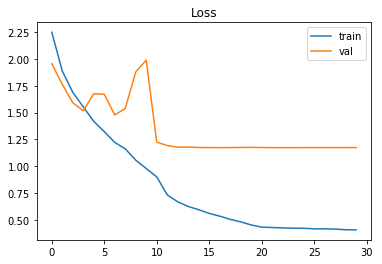

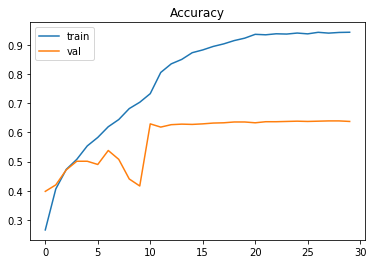

In [11]:
# densenet121, batch_size=32, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_ds121, loss_log, acc_log = train_model_batch(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30, batch_accum=8)

Epoch 0/29
----------
train Loss: 2.2578 Acc: 0.2632
val Loss: 1.9953 Acc: 0.3505
lr:  0.0001

Epoch 1/29
----------
train Loss: 1.8570 Acc: 0.4162
val Loss: 1.7096 Acc: 0.4646
lr:  0.0001

Epoch 2/29
----------
train Loss: 1.6577 Acc: 0.4636
val Loss: 1.6340 Acc: 0.4848
lr:  0.0001

Epoch 3/29
----------
train Loss: 1.5228 Acc: 0.5136
val Loss: 1.5821 Acc: 0.5189
lr:  0.0001

Epoch 4/29
----------
train Loss: 1.4028 Acc: 0.5518
val Loss: 1.5144 Acc: 0.5317
lr:  0.0001

Epoch 5/29
----------
train Loss: 1.2837 Acc: 0.5909
val Loss: 1.4536 Acc: 0.5345
lr:  0.0001

Epoch 6/29
----------
train Loss: 1.2049 Acc: 0.6162
val Loss: 1.9421 Acc: 0.4968
lr:  0.0001

Epoch 7/29
----------
train Loss: 1.1816 Acc: 0.6305
val Loss: 1.4728 Acc: 0.5225
lr:  0.0001

Epoch 8/29
----------
train Loss: 1.0982 Acc: 0.6516
val Loss: 1.5709 Acc: 0.5455
lr:  0.0001

Epoch 9/29
----------
train Loss: 0.9937 Acc: 0.6990
val Loss: 2.0247 Acc: 0.4701
lr:  0.0001

Epoch 10/29
----------
train Loss: 0.9810 Acc: 0.7

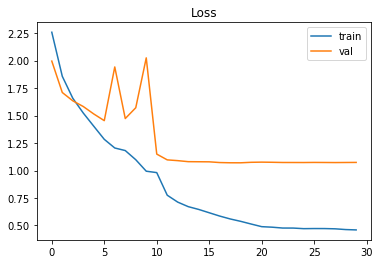

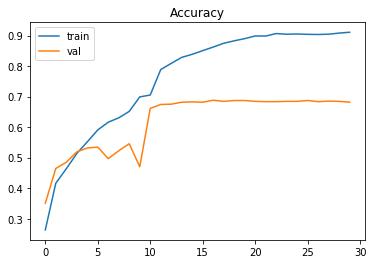

In [15]:
# densenet121, batch_size=32, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_ds121, loss_log, acc_log = train_model_batch(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30, batch_accum=8)

Epoch 0/29
----------
train Loss: 2.1989 Acc: 0.3106
val Loss: 1.9332 Acc: 0.3983
lr:  0.0001

Epoch 1/29
----------
train Loss: 1.8190 Acc: 0.4289
val Loss: 1.6560 Acc: 0.4830
lr:  0.0001

Epoch 2/29
----------
train Loss: 1.6355 Acc: 0.4804
val Loss: 1.5496 Acc: 0.5032
lr:  0.0001

Epoch 3/29
----------
train Loss: 1.4894 Acc: 0.5288
val Loss: 1.5319 Acc: 0.5023
lr:  0.0001

Epoch 4/29
----------
train Loss: 1.3687 Acc: 0.5695
val Loss: 1.5037 Acc: 0.5373
lr:  0.0001

Epoch 5/29
----------
train Loss: 1.2757 Acc: 0.5923
val Loss: 1.3921 Acc: 0.5529
lr:  0.0001

Epoch 6/29
----------
train Loss: 1.1859 Acc: 0.6279
val Loss: 1.7599 Acc: 0.5097
lr:  0.0001

Epoch 7/29
----------
train Loss: 1.1273 Acc: 0.6496
val Loss: 1.7174 Acc: 0.4600
lr:  0.0001

Epoch 8/29
----------
train Loss: 1.0554 Acc: 0.6654
val Loss: 1.4277 Acc: 0.5446
lr:  0.0001

Epoch 9/29
----------
train Loss: 1.0413 Acc: 0.6742
val Loss: 2.0511 Acc: 0.4784
lr:  0.0001

Epoch 10/29
----------
train Loss: 1.0236 Acc: 0.6

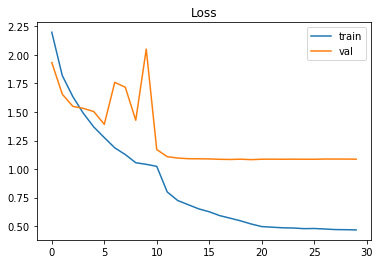

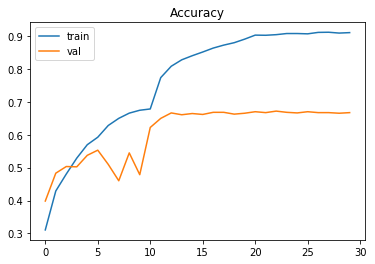

In [18]:
# densenet121, batch_size=32, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_ds121, loss_log, acc_log = train_model_batch(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30, batch_accum=8)